In [1]:
import tensorflow as tf
from math import ceil
from configuration import *

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.9.0


In [2]:
if tf.test.gpu_device_name(): 
    print("Default GPU: {}".format(tf.test.gpu_device_name()))
else:
    print("Not using a GPU - it will take long!!")

Default GPU: /device:GPU:0


In [3]:
print("DATASET_SIZE", DATASET_SIZE)
print("TRAIN_SIZE", TRAIN_SIZE)
print("TEST_SIZE", TEST_SIZE)

tf.random.set_seed(SEED)
print(TRAIN_SIZES)
print(TEST_SIZES)

DATASET_SIZE 294
TRAIN_SIZE 250
TEST_SIZE 44
[0, 0, 250, 0, 0]
[0, 0, 44, 0, 0]


In [4]:
# from dataset_utils import create_paired_s2s_image_loader as create_image_loader
# from dataset_utils import create_augmentation_with_prob, normalize_two as normalize
from dataset_utils import create_paired_s2s_image_loader_indexed_images as create_image_loader

train_dataset = tf.data.Dataset.range(TRAIN_SIZE).shuffle(TRAIN_SIZE)
test_dataset = tf.data.Dataset.range(TEST_SIZE).shuffle(TEST_SIZE)

f2r_train_dataset = train_dataset.map(create_image_loader(2, 3, TRAIN_SIZES, "train"), num_parallel_calls=tf.data.AUTOTUNE)
# # f2r_train_dataset = f2r_train_dataset.map(create_augmentation_with_prob(0.8), num_parallel_calls=tf.data.AUTOTUNE)
# f2r_train_dataset = f2r_train_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
f2r_train_dataset = f2r_train_dataset.batch(BATCH_SIZE)
f2r_test_dataset = test_dataset.map(create_image_loader(2, 3, TEST_SIZES, "test"), num_parallel_calls=tf.data.AUTOTUNE)
# f2r_test_dataset = f2r_test_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
f2r_test_dataset = f2r_test_dataset.batch(BATCH_SIZE)

# f2b_train_dataset = train_dataset.map(create_image_loader(2, 3, TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
# f2b_train_dataset = f2b_train_dataset.batch(BATCH_SIZE)
# f2b_test_dataset = test_dataset.map(create_image_loader(2, 3, TEST_SIZES, "test", False))
# f2b_test_dataset = f2b_test_dataset.batch(BATCH_SIZE)
#
# f2l_train_dataset = train_dataset.map(create_image_loader(2, 1, TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
# f2l_train_dataset = f2l_train_dataset.batch(BATCH_SIZE)
# f2l_test_dataset = test_dataset.map(create_image_loader(2, 1, TEST_SIZES, "test", False))
# f2l_test_dataset = f2l_test_dataset.batch(BATCH_SIZE)

In [5]:
# ds = f2r_test_dataset
# for i, data in ds.enumerate():
#     print("i", i)

In [6]:
# model.generator.summary()
# from networks import UnetDiscriminator
#
# dsc = UnetDiscriminator()
# dsc.summary(expand_nested=True)

In [7]:
# tf.repeat([[255, 0, 220, 255]], [MAX_PALETTE_SIZE - 56,], axis=0)

In [8]:
# from matplotlib import pyplot as plt
# plt.figure(figsize=(8, 8))
# plt.title("Indexed generated at 0")
# plt.imshow(fake_image)
# plt.axis("off")

In [9]:
# from pix2pix_model import Unet2Generator
# gen = Unet2Generator()
# gen.summary()

In [10]:
from pix2pix_model import Pix2PixModel, Pix2PixIndexedModel#, Pix2PixWassersteinModel#, Pix2PixFFTModel

# f2r = Pix2PixFFTModel(f2r_train_dataset, f2r_test_dataset, "front2right", "pix2pix-rpgmakerxp-fftsquare1000", LAMBDA_FFT=1000)
model = Pix2PixModel.build(f2r_train_dataset, f2r_test_dataset, "sbgames", "sbgames", "patch", "unet", "gan", discriminator_steps=1, lambda_histogram=0., lambda_l1=100., lambda_gp=10.)
# model = Pix2PixIndexedModel(f2r_train_dataset, f2r_test_dataset, "indexed-54", "aiide", "indexed-patch", "indexed-unet", "gan", discriminator_steps=1, lambda_l1=0., lambda_segmentation=0.01, lambda_histogram=0.)


D:\Projetos 2\pixel-sides\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Generator: unet-gen with 29,307,844 parameters
Discriminator: patch-disc with 9,217 parameters
Mode gan with binary_crossentropy loss


In [11]:
# model.discriminator.summary(expand_nested=True)

In [12]:
# STEPS = 40000
# EPOCHS = ceil(TRAIN_SIZE / BATCH_SIZE)
EPOCHS = 160
STEPS = ceil(TRAIN_SIZE / BATCH_SIZE) * EPOCHS
UPDATE_STEPS = STEPS // 40
SHOULD_SAVE_RESULTS = True
SHOULD_GENERATE_ALL_IMAGES_FROM_TEST = True

print(f"Starting training for {EPOCHS} epochs in {STEPS} steps, updating visualization every {UPDATE_STEPS} steps...")

Starting training for 160 epochs in 10080 steps, updating visualization every 252 steps...


Time since start: 01h:00m:54s
Estimated time to finish: 00m:00s
Last 252 steps took: 85.63s



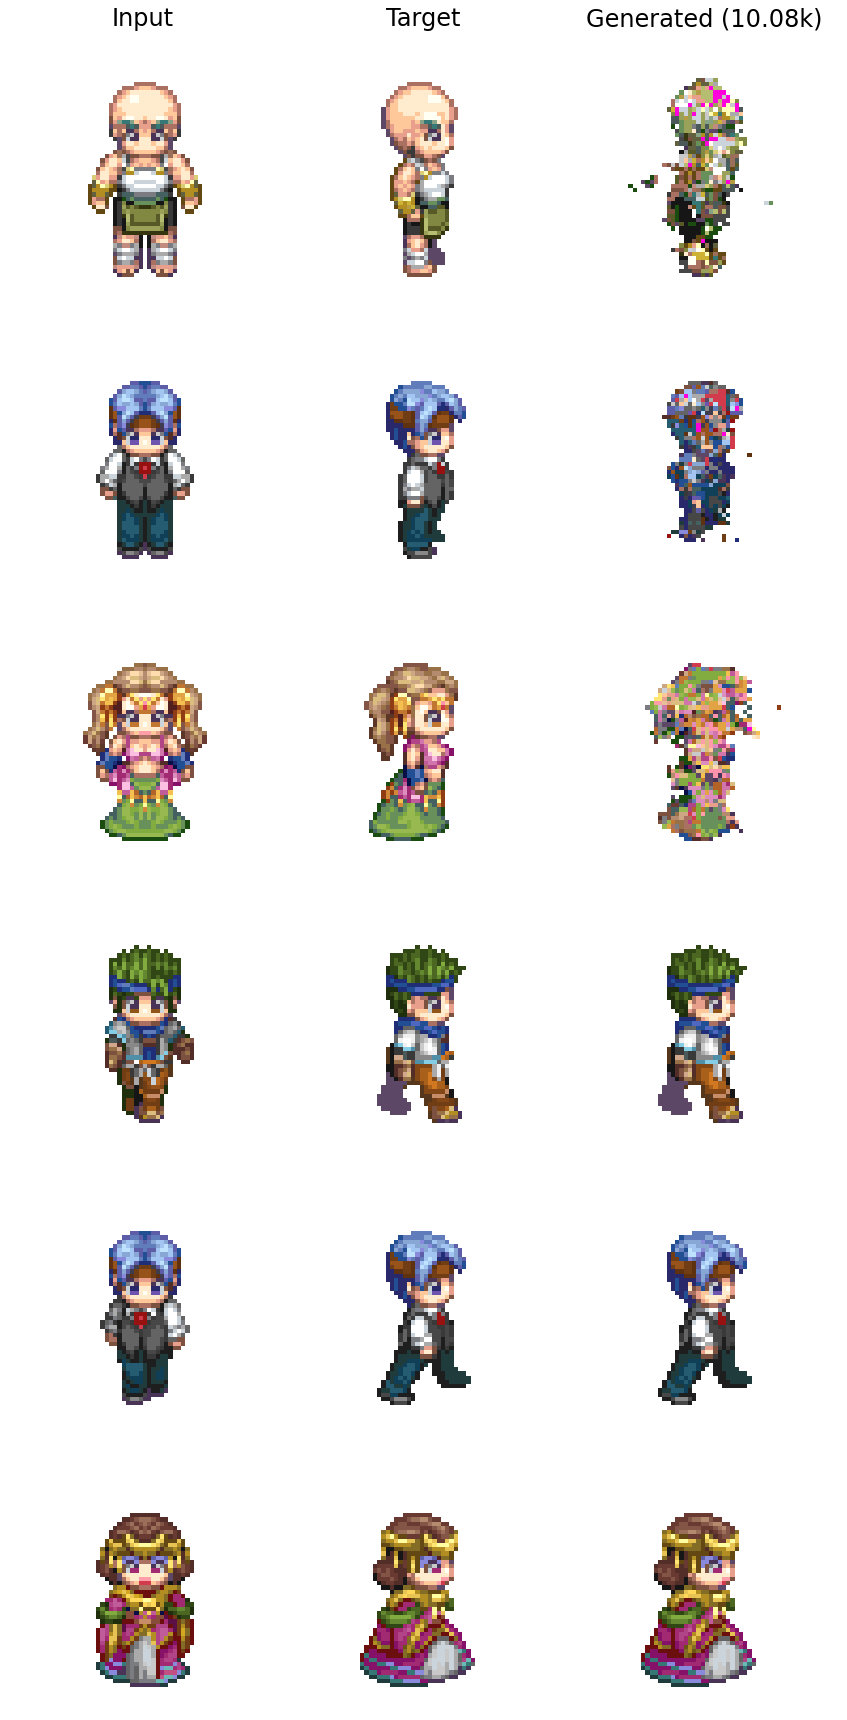

Showing discriminator patches...


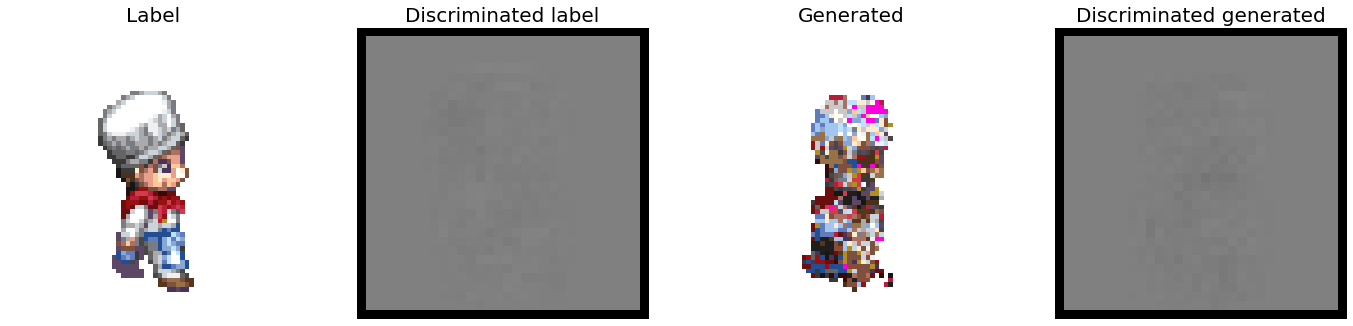

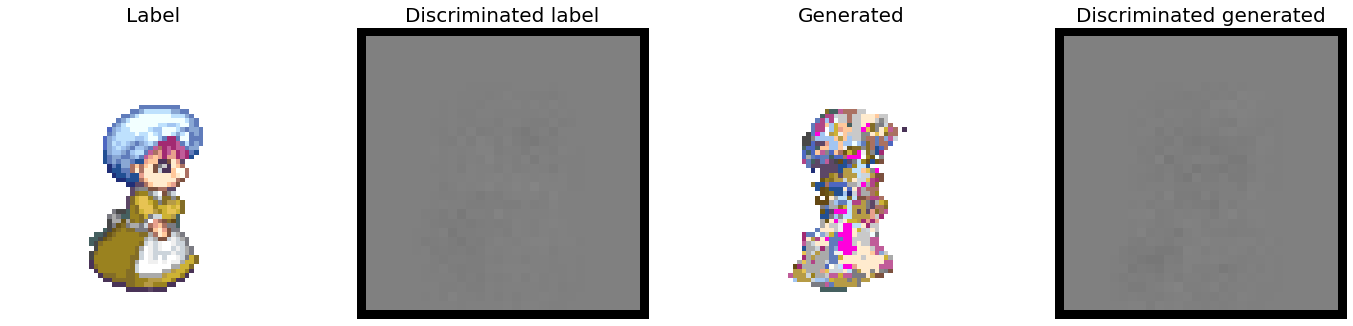

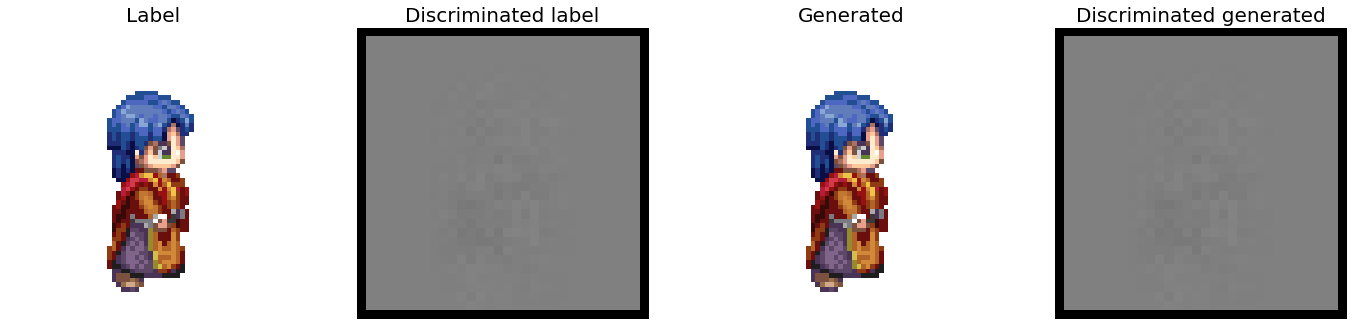

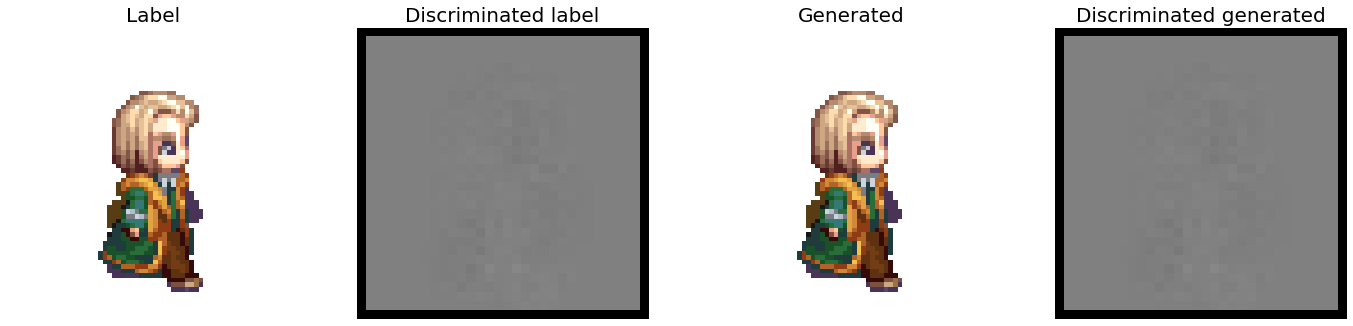

Comparing L1 between generated images from train and test... L1: 0.00102 / 10.50886 (train/test)
2/2 [==============================] - 0s 238ms/step
 FID: 0.083 / 132.261 (train/test)
Step: 10.08k


In [13]:
model.fit(STEPS, UPDATE_STEPS, callbacks=["show_patches", "fid", "l1"])


In [14]:
# print("More training...")
# model.save_generator()
# model = Pix2PixModel(f2r_train_dataset, f2r_test_dataset, "front2right", "pix2pix-rpgmakerxp-unetafterunet-unet", "unet", "unet", LAMBDA=100.)
# model.generator = tf.keras.models.load_model(os.sep.join(["models", "py", "generator", "pix2pix-rpgmakerxp-unet-unet", "front2right"]))
# model.fit(STEPS, UPDATE_STEPS, callbacks=["fid", "show_patches"])

def show_classification(dataset_name):
    dataset = model.train_ds if dataset_name == "train" else model.test_ds
    batch = next(iter(dataset.unbatch().batch(44).take(1)))
    source, real = batch#[0], batch[1]
    fake = model.generator(source, training=True)

    _, real_classification = model.discriminator([real, source], training=True)
    _, fake_classification = model.discriminator([fake, source], training=True)

    loss = model.bce

    print(f"classification on {dataset_name} real", real_classification)
    print(f"classification on {dataset_name} fake", fake_classification)

    print(f"generator cls loss on {dataset_name}", loss(tf.ones_like(fake_classification), fake_classification))
    print(f"disc. real cls loss on {dataset_name}", loss(tf.ones_like(real_classification), real_classification))
    print(f"disc. fake cls loss on {dataset_name}", loss(tf.zeros_like(fake_classification), fake_classification))
# show_classification("test")

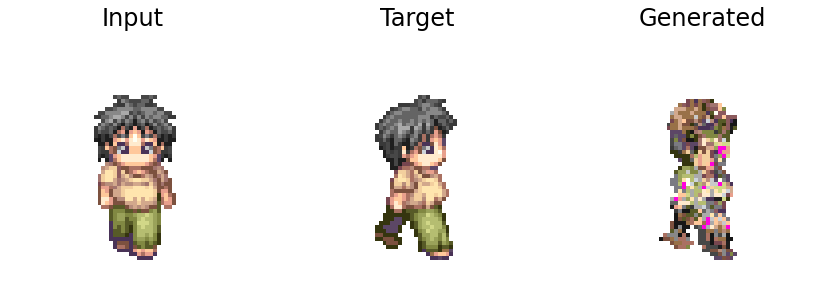

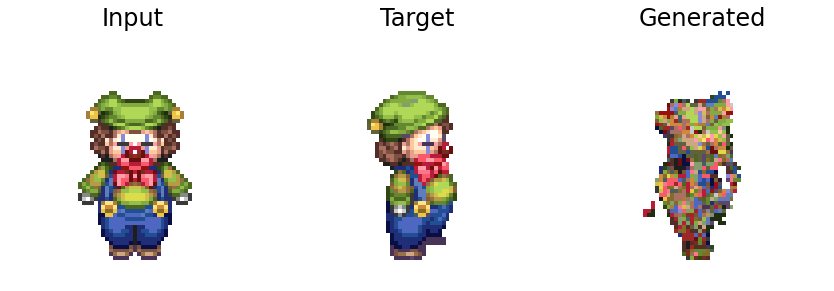

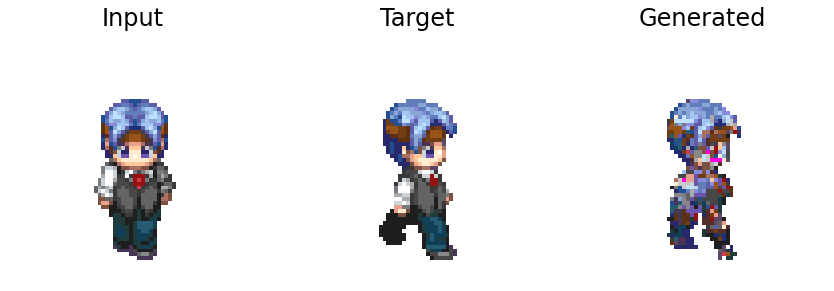

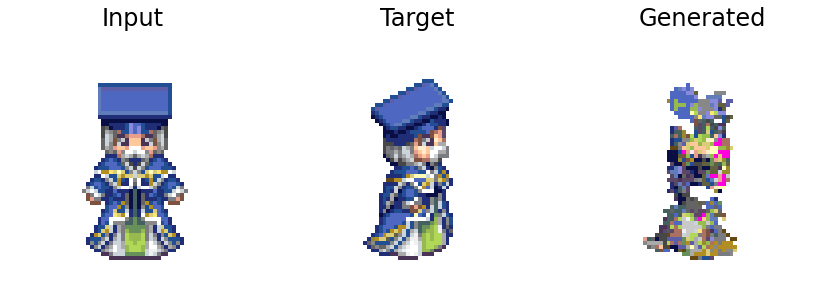

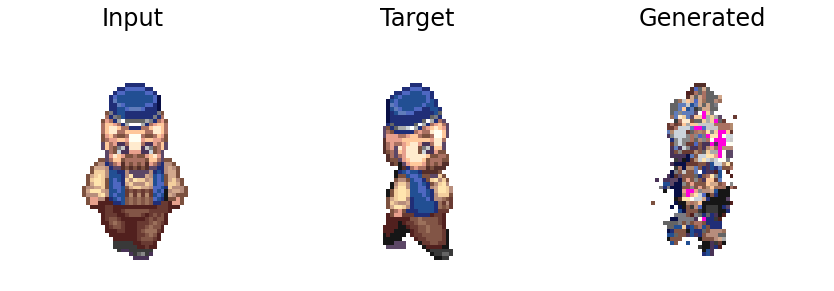

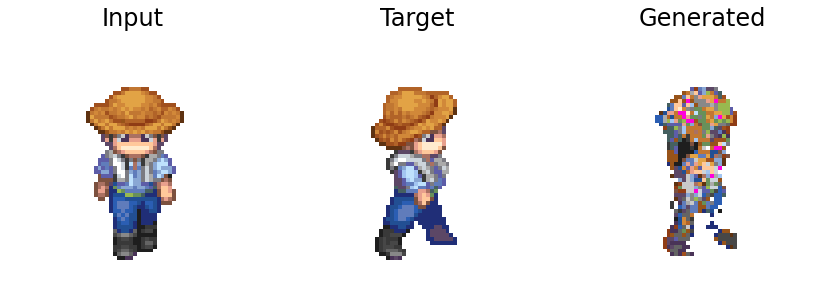

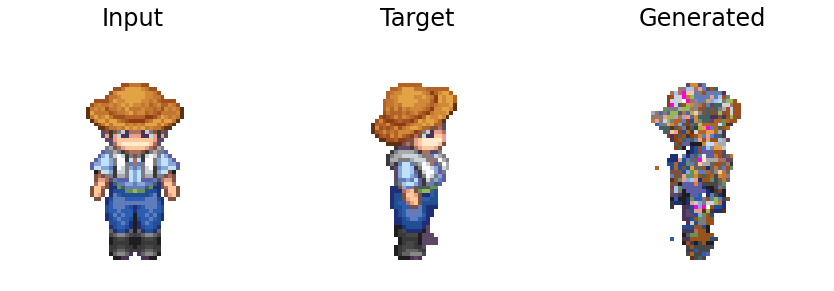

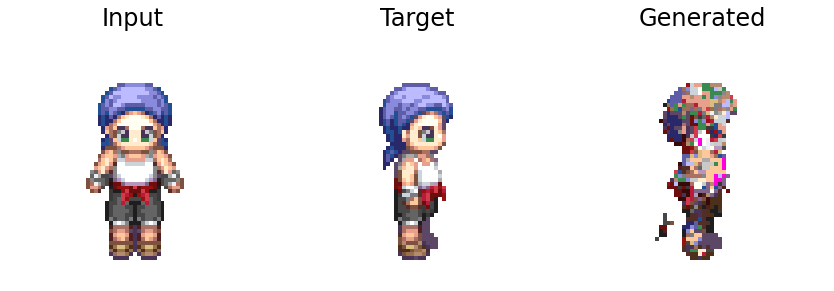

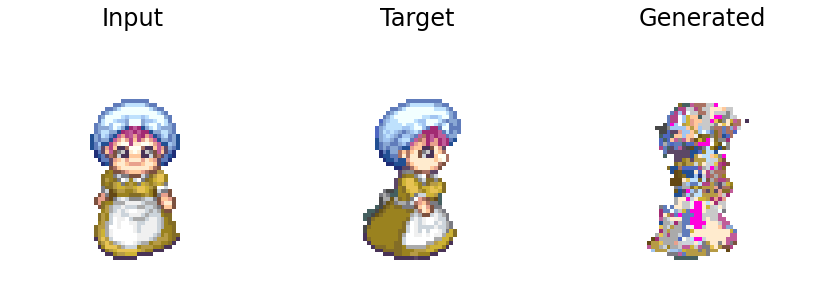

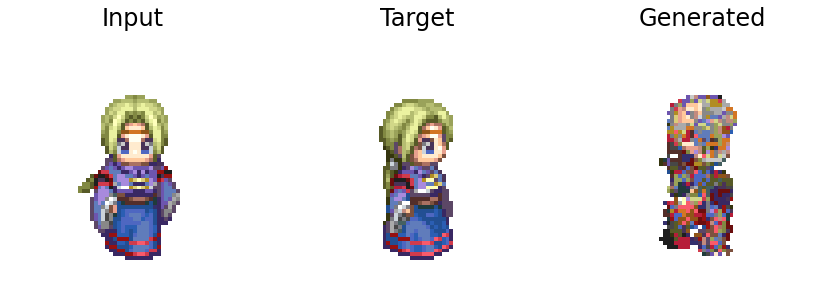

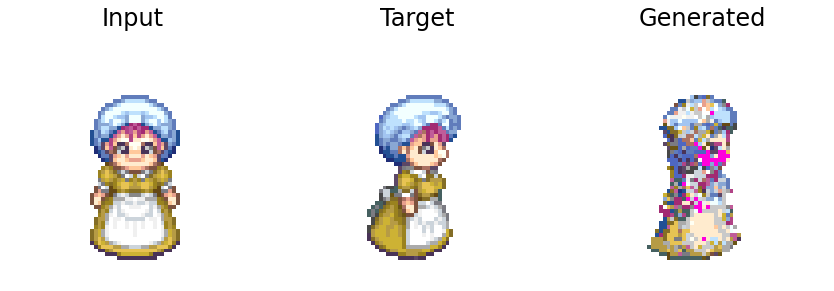

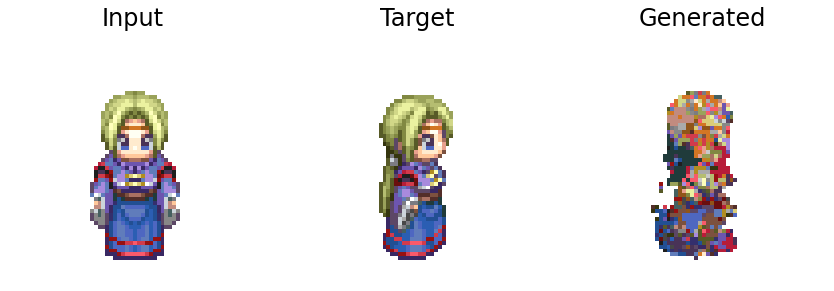

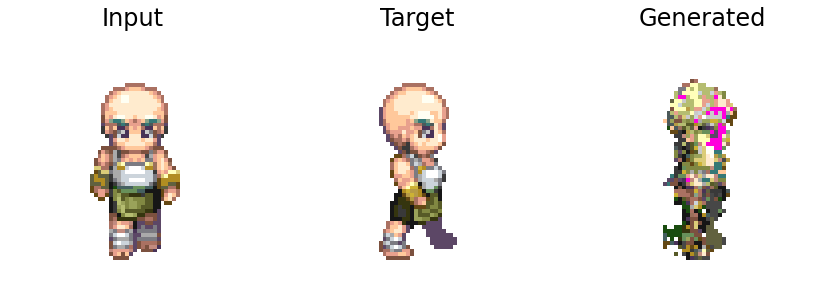

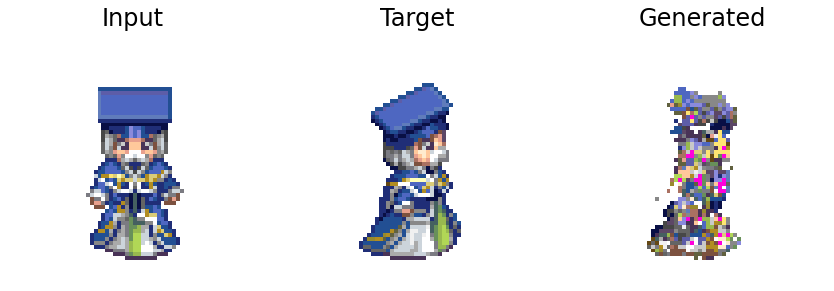

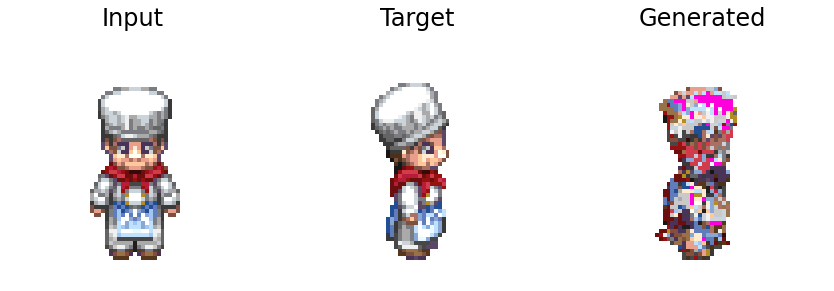

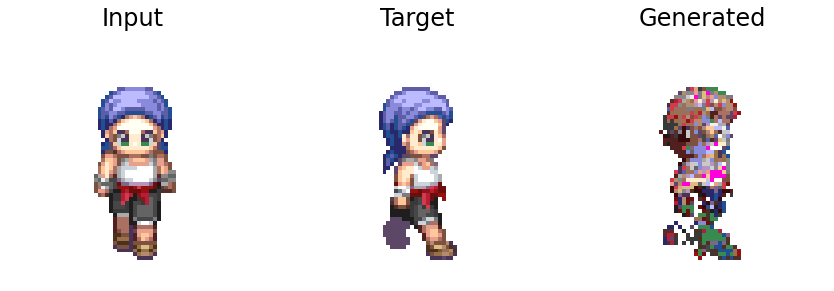

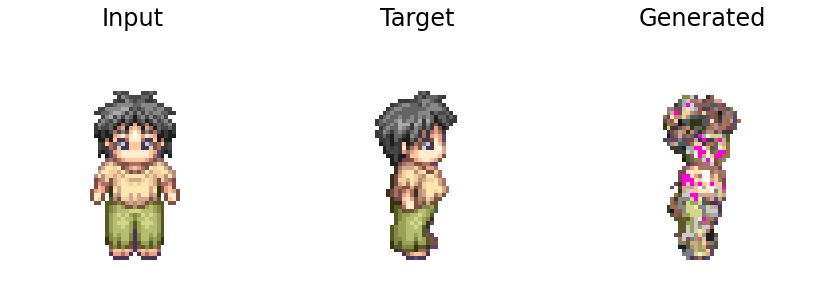

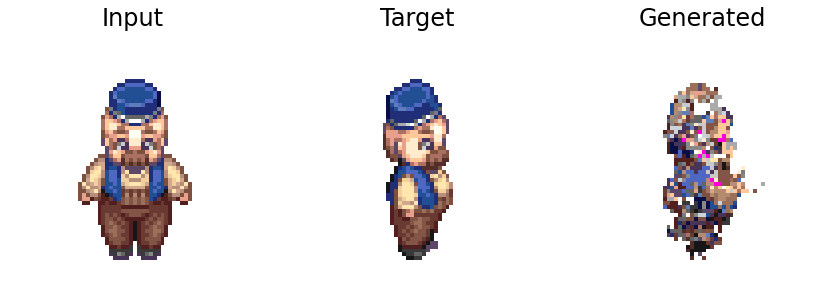

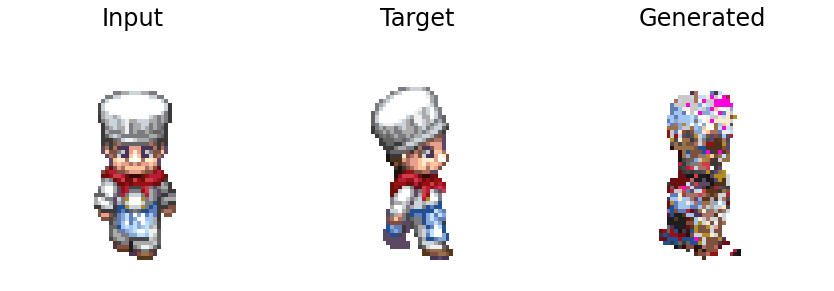

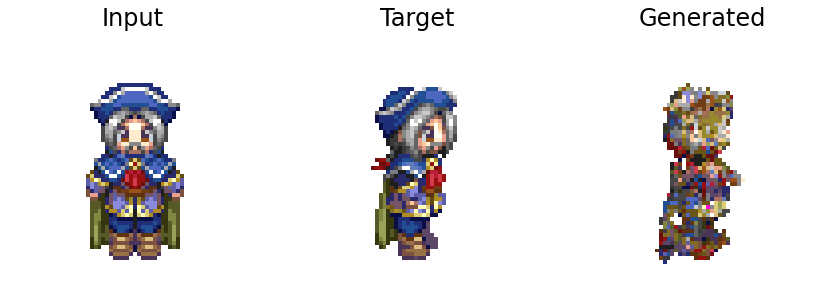

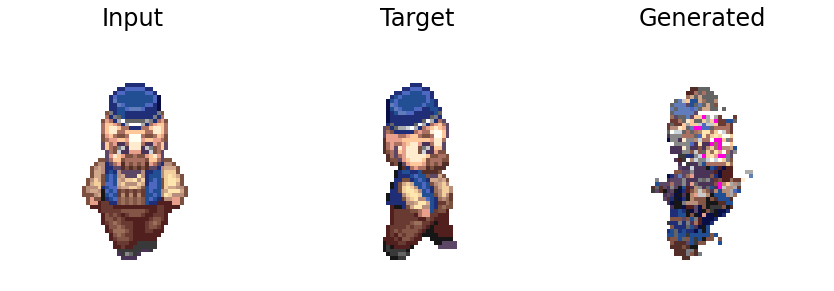

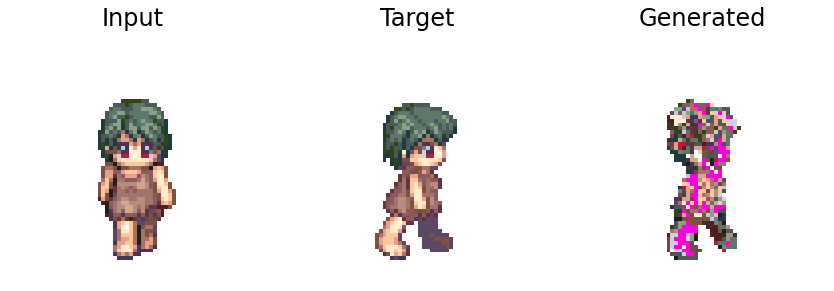

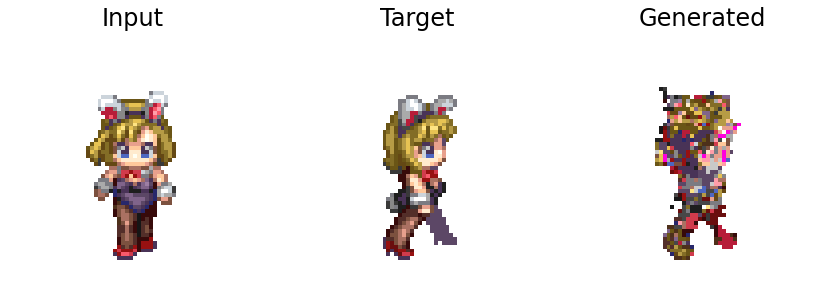

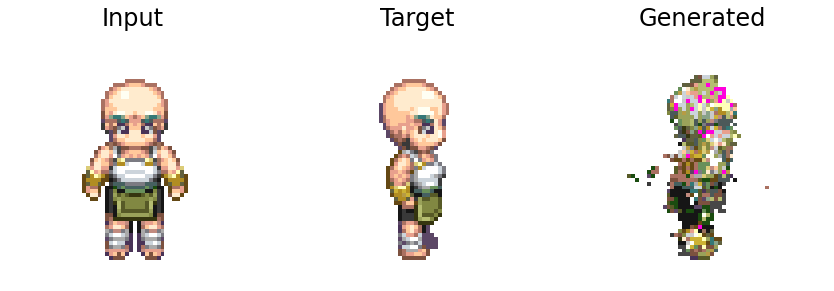

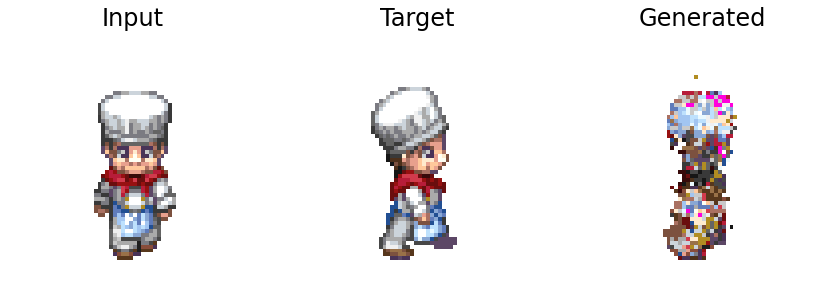

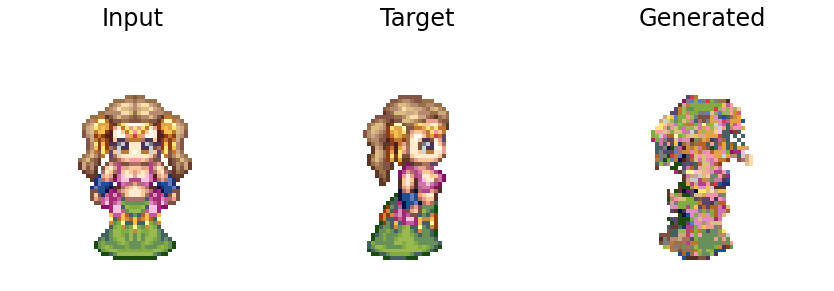

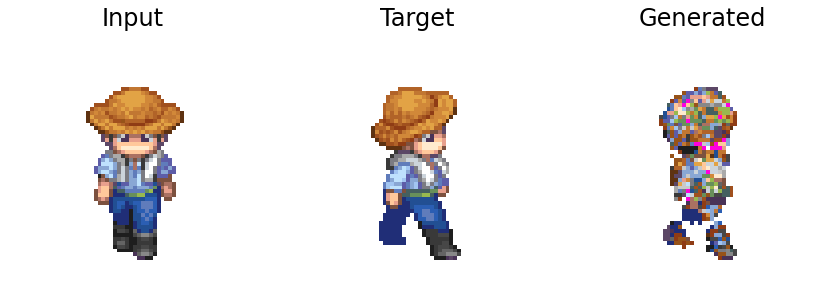

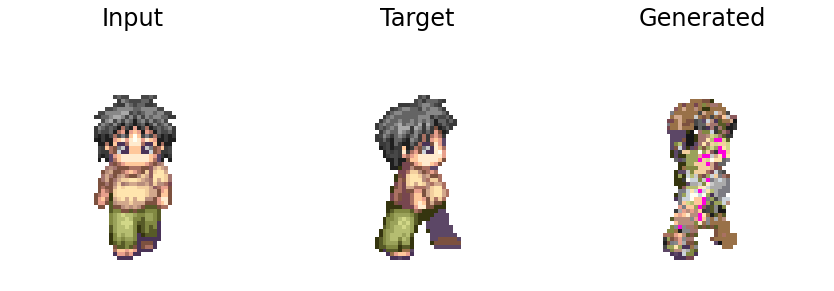

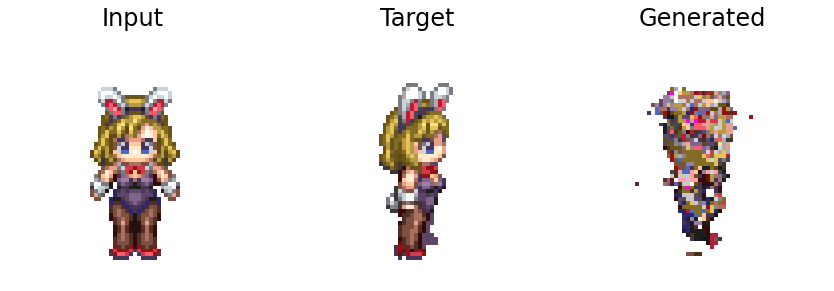

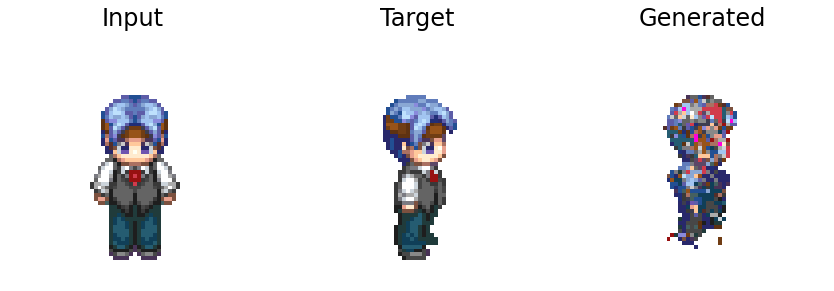

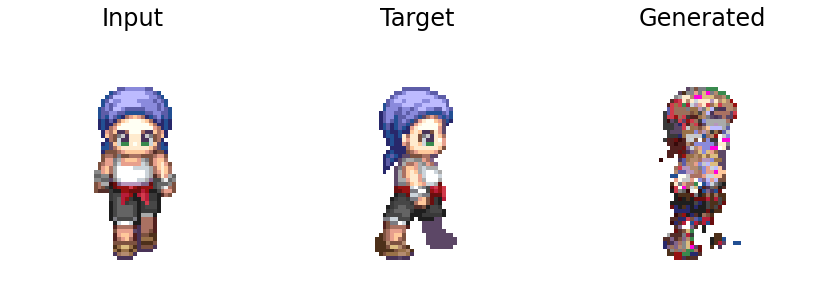

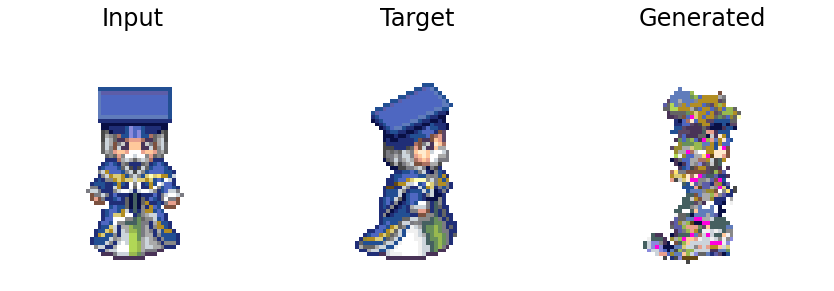

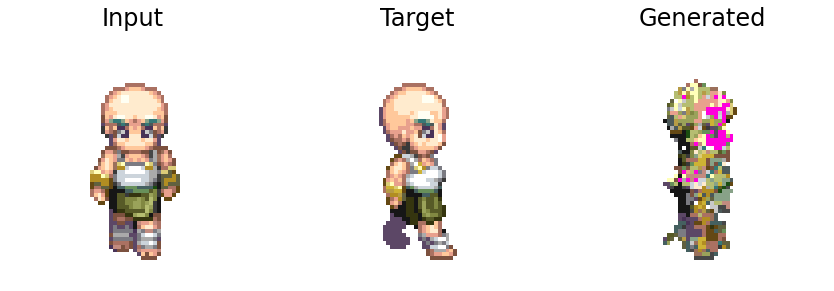

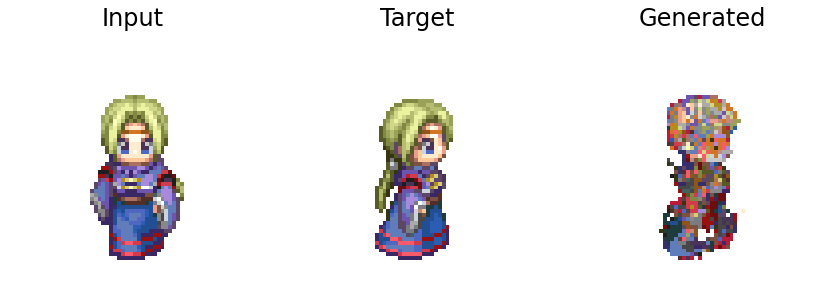

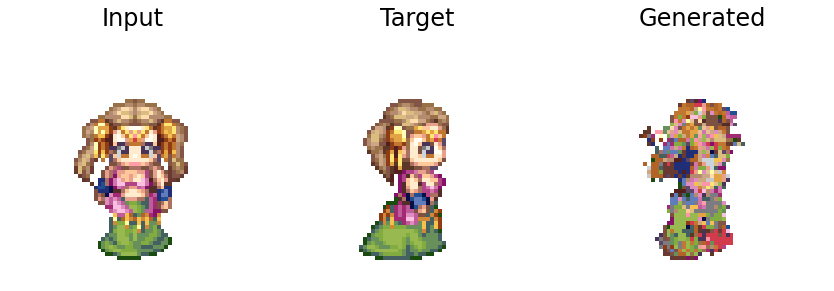

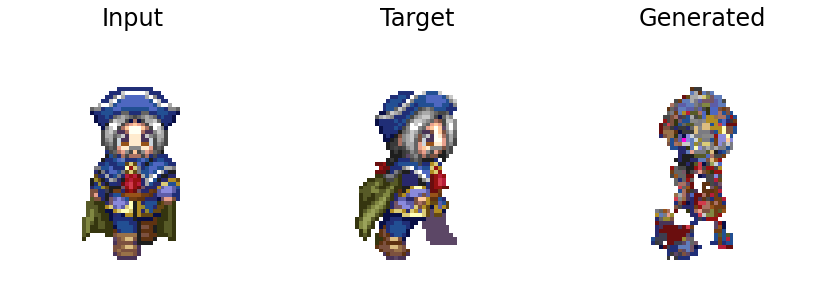

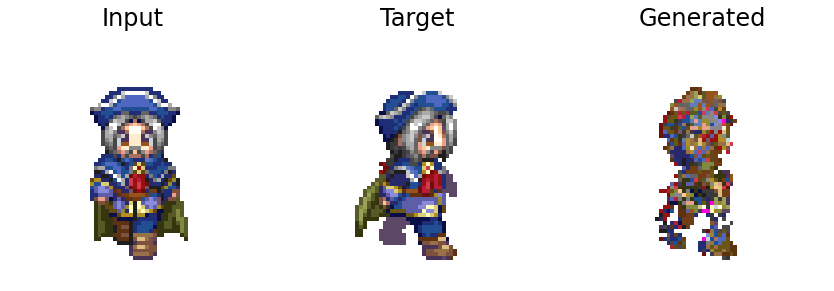

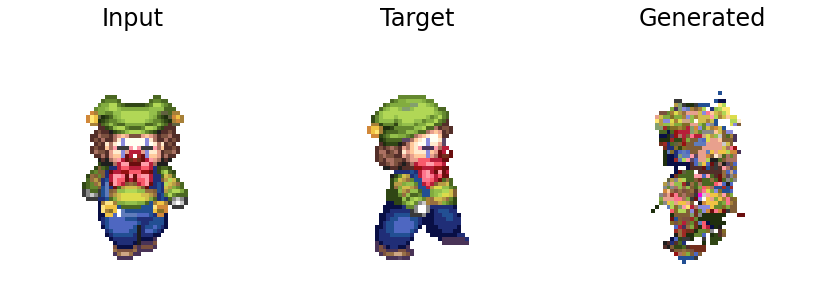

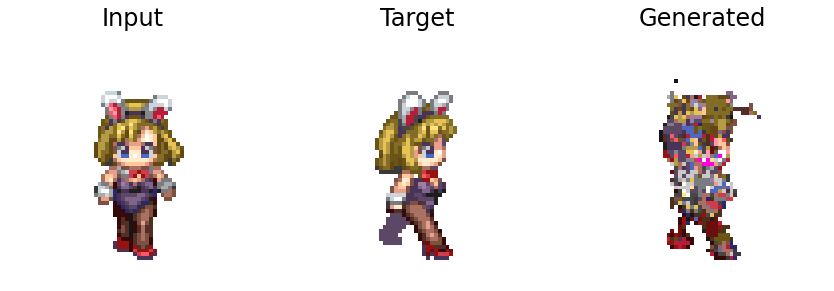

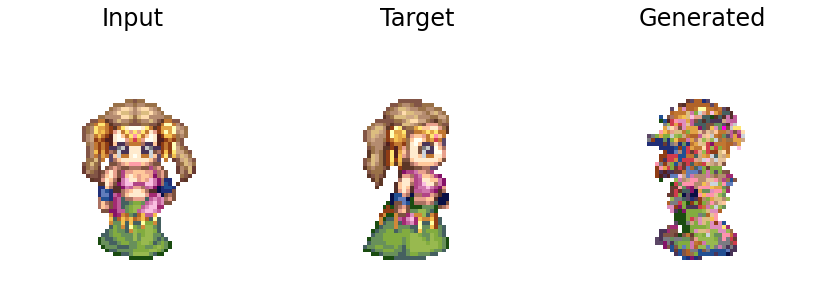

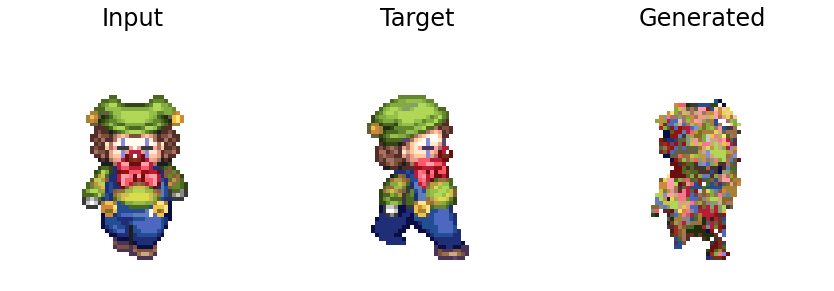

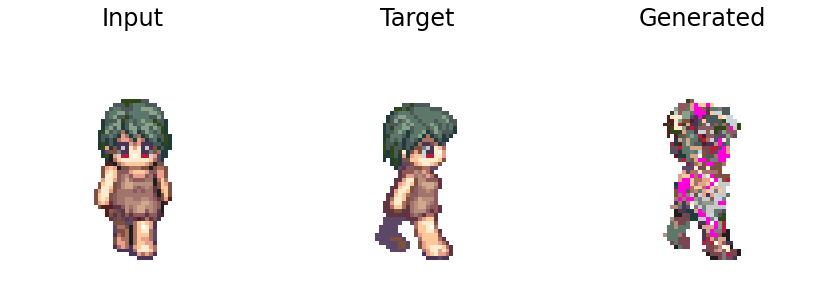

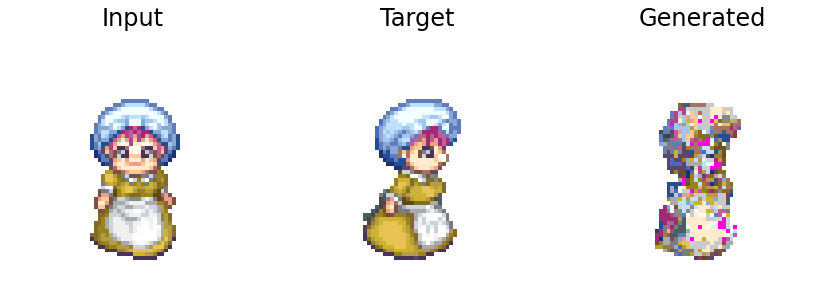

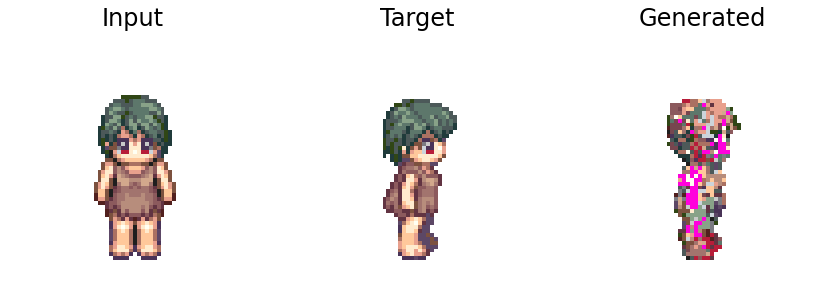

Generated 44 images (using "test" dataset)


In [15]:
if SHOULD_GENERATE_ALL_IMAGES_FROM_TEST:
    # f2r.load_generator()
    model.generate_images_from_dataset()

In [16]:
if SHOULD_SAVE_RESULTS:
    model.save_generator()
    model.save_discriminator()

INFO:tensorflow:Assets written to: models\py\generator\aiide\indexed-54\assets


INFO:tensorflow:Assets written to: models\py\generator\aiide\indexed-54\assets


INFO:tensorflow:Assets written to: models\py\discriminator\aiide\indexed-54\assets


INFO:tensorflow:Assets written to: models\py\discriminator\aiide\indexed-54\assets


Showing discriminator output from TRAIN set...


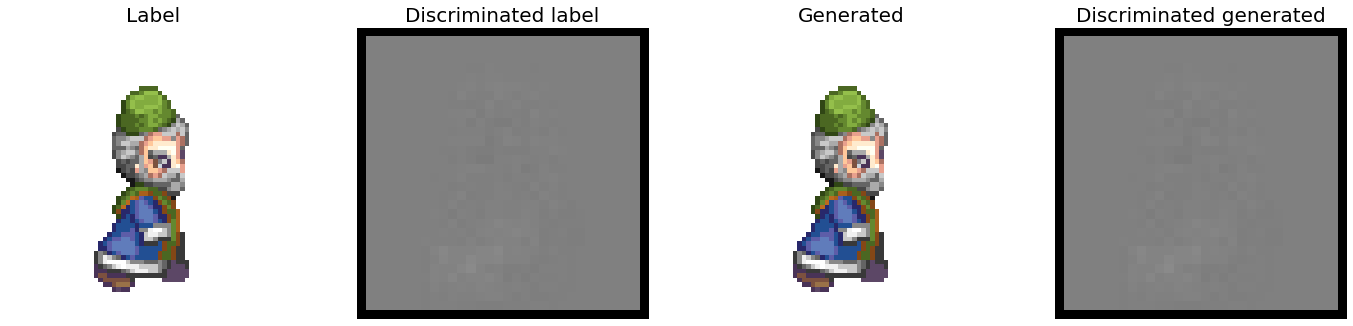

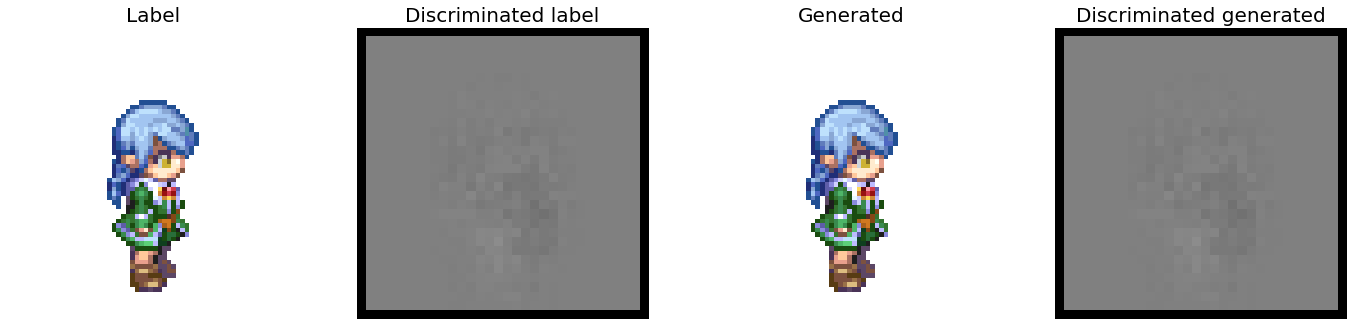

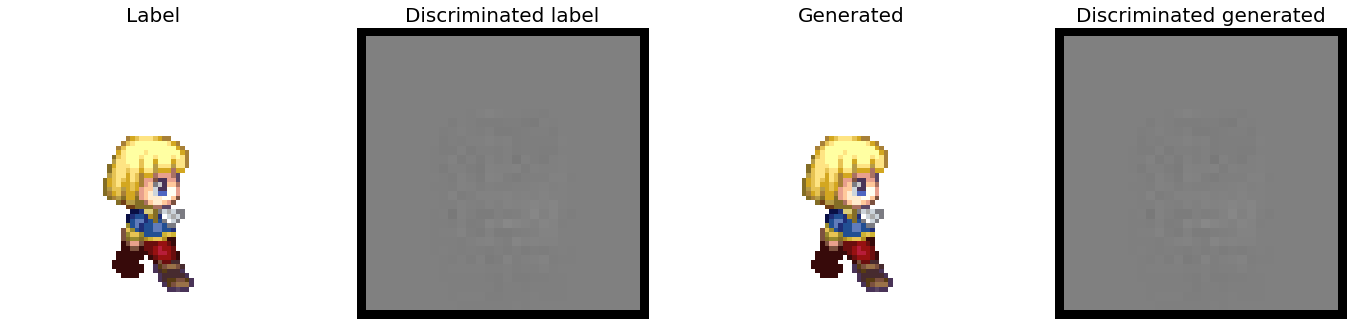

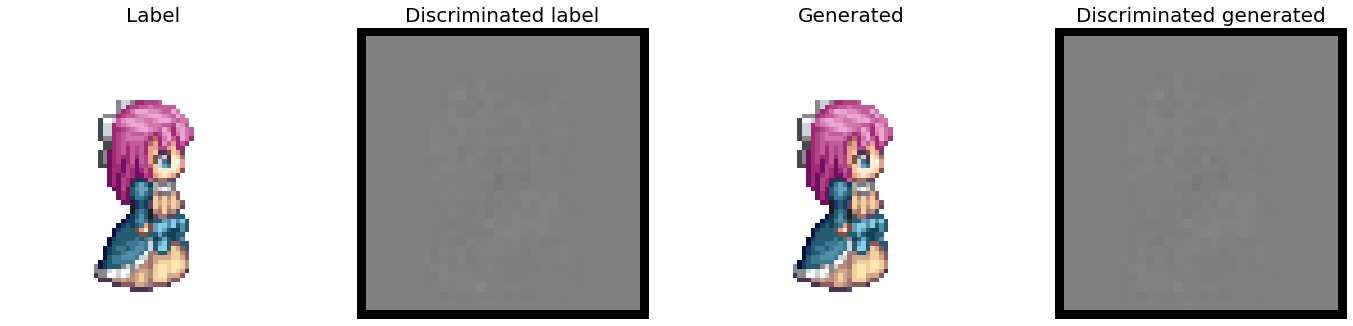

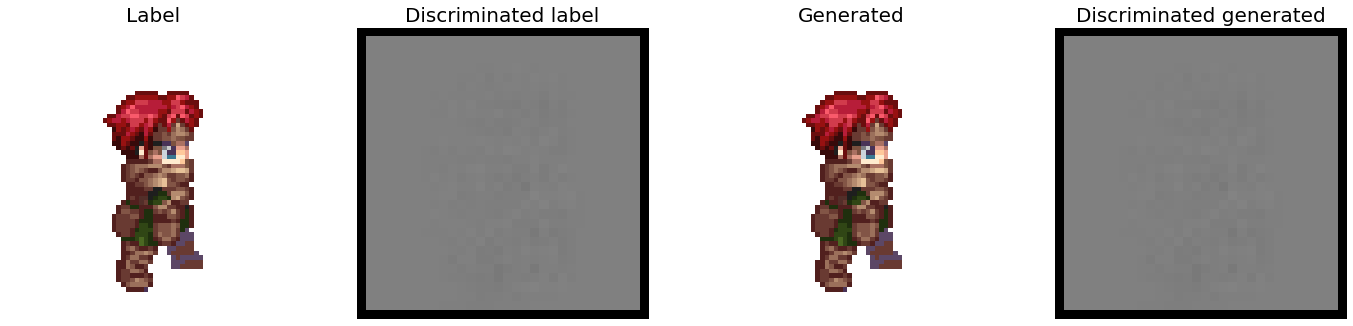

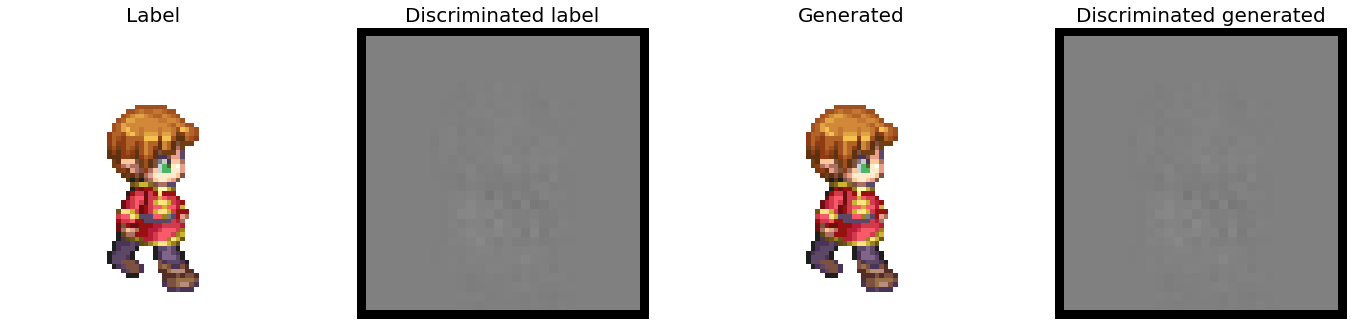

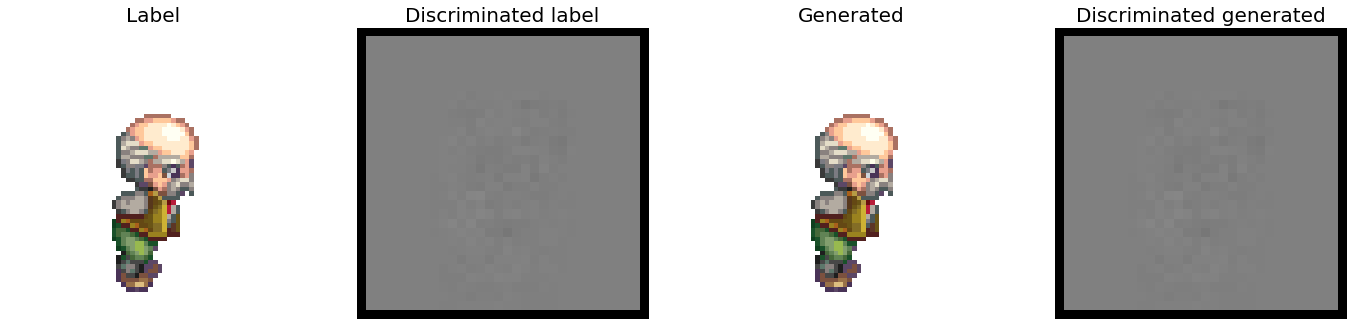

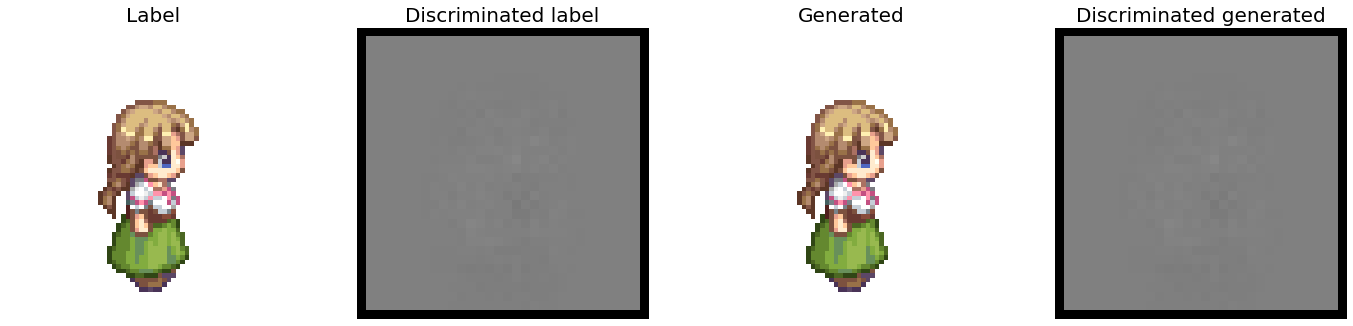

Showing discriminator output from TEST set...


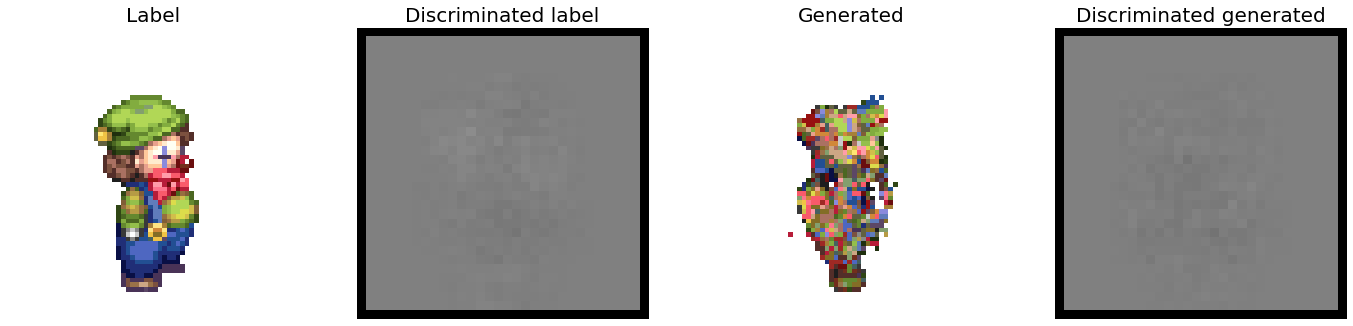

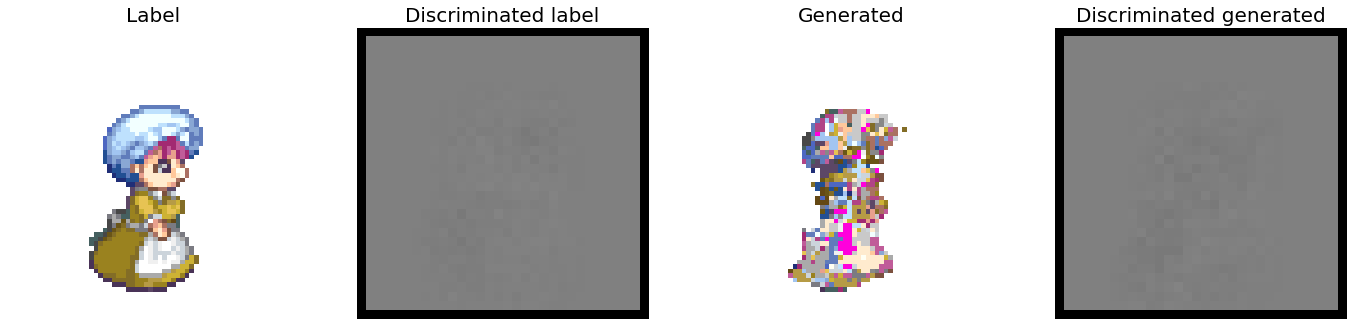

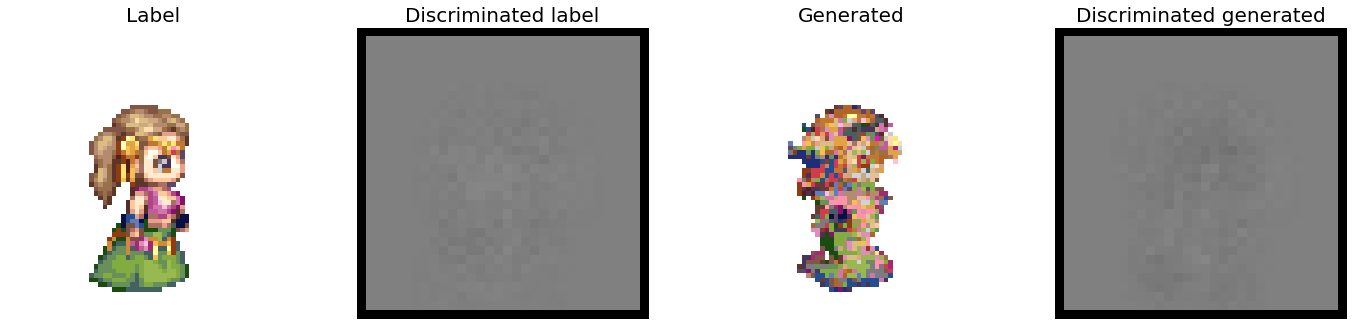

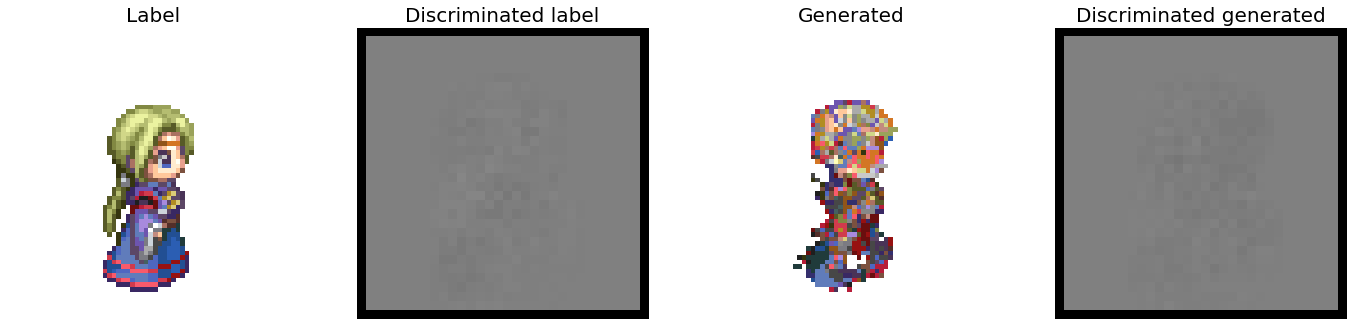

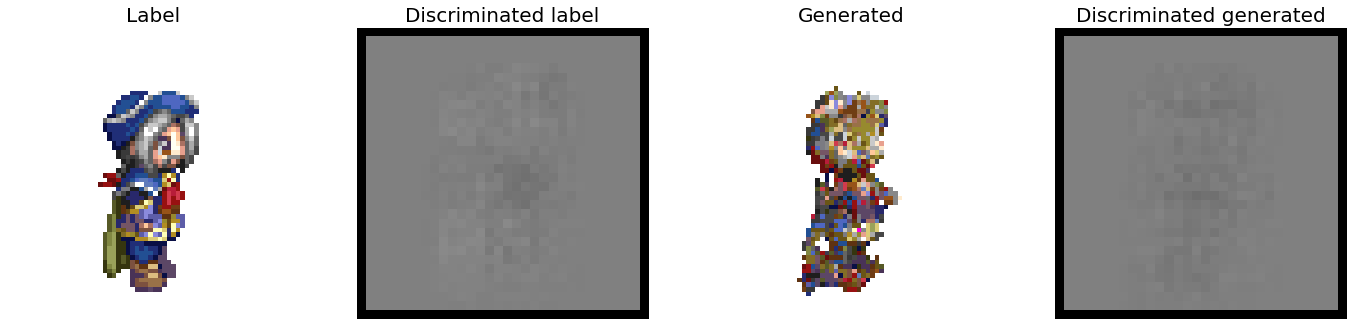

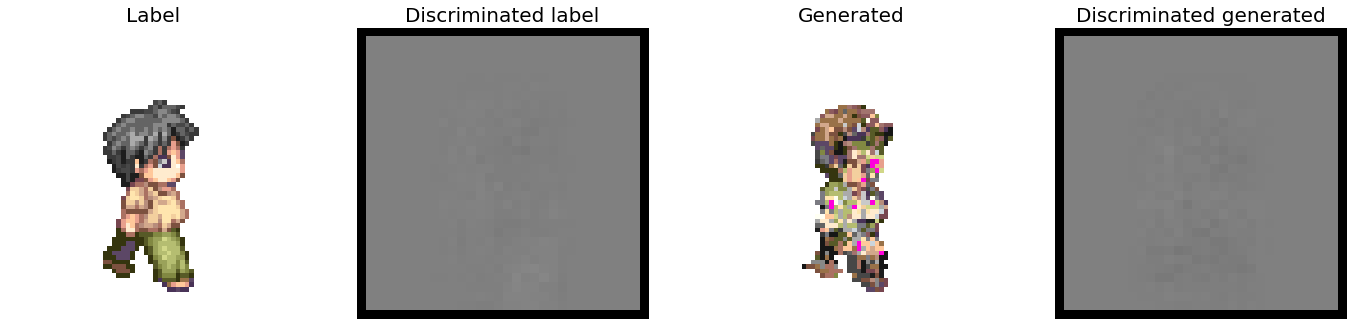

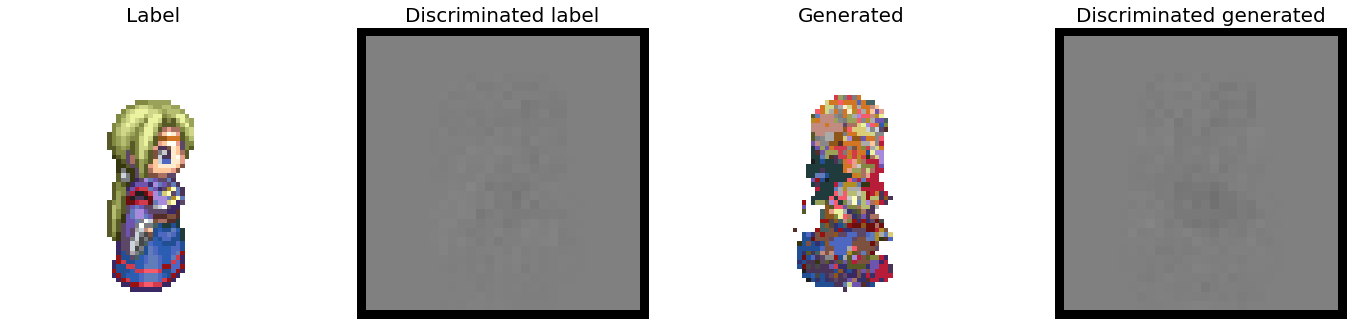

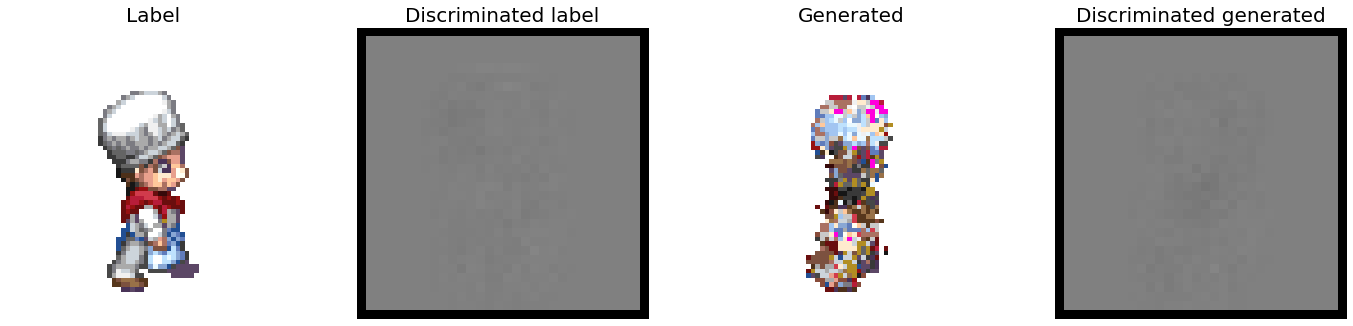

In [17]:
print("Showing discriminator output from TRAIN set...")
model.show_discriminated_images("train", 8)
print("Showing discriminator output from TEST set...")
model.show_discriminated_images("test", 8)

In [18]:
# model.load_generator()
# model.generate_images_from_dataset(dataset_name="train", num_images=3)
#
# print("Discriminated images from test")
# model.load_discriminator()
# model.show_discriminated_images("train")